# Set up simple CNN with radar data

In [1]:
import iris
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils

## Work with data from S3 bucket:

In [3]:
files = [f'/s3/mo-uki-radar-comp/20180915{h:02}{m:02}_nimrod_ng_radar_rainrate_composite_500m_UK' \
          for m in range(0,60,5) for h in range(6,11)]

## Read data and reshape into groups of 10 timesteps on a 100x100 grid:

In [4]:
cubes = iris.load(files)
cube = cubes[0]/32
cube = cube[:10*(cube.shape[0]//10), 1000:3000, 1000:2000]
cube_data = cube.data
print(np.shape(cube_data))
split_data_1 = np.stack(np.split(cube_data, cube_data.shape[0]/10))
print(np.shape(split_data_1))
split_data_1 = np.stack(np.split(split_data_1, cube_data.shape[1]/100, -2))
print(np.shape(split_data_1))
split_data_1 = np.stack(np.split(split_data_1, cube_data.shape[2]/100, -1))
print(np.shape(split_data_1))
dataset = split_data_1.reshape(-1,10,100,100)
print(np.shape(dataset))

/opt/conda/lib/python3.6/site-packages/iris/fileformats/nimrod_load_rules.py:246: TranslationWarning: Vertical coord 5 not yet handled
  "".format(v_type), TranslationWarning)


(60, 2000, 1000)
(6, 10, 2000, 1000)
(20, 6, 10, 100, 1000)
(10, 20, 6, 10, 100, 100)
(1200, 10, 100, 100)


## Convert to torch tensors and load as training dataset

In [5]:
# Convert to torch tensors
tensor = torch.stack([torch.Tensor(i) for i in dataset])

In [6]:
train_loader = utils.DataLoader(tensor, batch_size=1)

## Create validation dataset

In [16]:
def create_regridded_cube():
    '''
    Function to create cube with desired grid domain, resolution and co-ordinate system.
    Outputs: regrid_cube - empty cube with desired characteristics
             cs - co-ordinate system
    '''
    latitude = iris.coords.DimCoord(np.arange(53.5, 54.5, 0.01), #51, 52, 0.01),
                                    standard_name='latitude',units='degrees')
    longitude = iris.coords.DimCoord(np.arange(-5., -4., 0.01), #-0.6, 0.4, 0.01),
                                     standard_name='longitude',units='degrees')
    regrid_cube = iris.cube.Cube(np.zeros((100, 100), np.float32),
                               dim_coords_and_dims=[(latitude,0),(longitude,1)])
    cs = iris.coord_systems.GeogCS(6371229)
    regrid_cube.coord('latitude').coord_system = cs
    regrid_cube.coord('longitude').coord_system = cs

    return regrid_cube, cs

In [17]:
def regrid_nimrod(cube):
    '''Regrid radar data for chosen domain and resolution'''
    regrid_cube, cs = create_regridded_cube()
    scheme = iris.analysis.Linear()
    final_cube = cube.regrid(regrid_cube, scheme)
    
    return final_cube

In [18]:
files3 = [f'/s3/mo-uki-radar-comp/20180925{h:02}{m:02}_nimrod_ng_radar_rainrate_composite_500m_UK' \
          for m in range(0,60,5) for h in range(6,11)]
cubes3 = iris.load(files3)
cube3 = cubes3[0]/32. #scale back to mm/hr
final_cube3 = regrid_nimrod(cube3)
cube_data3 = final_cube3.data
split_data3 = np.stack(np.split(cube_data3, cube_data3.shape[0]/10))
dataset3 = np.array(split_data3) 
tensor3 = torch.stack([torch.Tensor(i) for i in dataset3])

val_loader = utils.DataLoader(tensor3, batch_size=1)

/opt/conda/lib/python3.6/site-packages/iris/fileformats/nimrod_load_rules.py:246: TranslationWarning: Vertical coord 5 not yet handled
  "".format(v_type), TranslationWarning)


In [ ]:

## Load validation data in same structure as training data (set up common function to do these steps)

#files = [f'/s3/mo-uki-radar-comp/20180925{h:02}{m:02}_nimrod_ng_radar_rainrate_composite_500m_UK' \
#          for m in range(0,60,5) for h in range(6,11)]
#cubes = iris.load(files)
#cube = cubes[0]/32
#cube = cube[:10*(cube.shape[0]//10), 1000:3000, 1000:2000]
#cube_data = cube.data
#split_data_1 = np.stack(np.split(cube_data, cube_data.shape[0]/10))
#split_data_1 = np.stack(np.split(split_data_1, cube_data.shape[1]/100, -2))
#split_data_1 = np.stack(np.split(split_data_1, cube_data.shape[2]/100, -1))
#dataset = split_data_1.reshape(-1,10,100,100)

#tensor = torch.stack([torch.Tensor(i) for i in dataset])

#val_loader = utils.DataLoader(tensor, batch_size=1)

## Set up CNN

In [19]:
from torch.autograd import Variable
import torch.nn.functional as F

class CNN(torch.nn.Module):
    
    def __init__(self):
        self.as_super = super(CNN, self)
        self.as_super.__init__()

        self.conv1 = torch.nn.Conv2d(5, 6, kernel_size=5, stride=1, padding=2)
        self.deconv1 = torch.nn.ConvTranspose2d(6, 5, kernel_size=5, stride=1, padding=2)
        
        self.conv_1 = torch.nn.Conv2d(5, 5, kernel_size=3, stride=1, padding=1)
        
    def forward(self, x):
        orig = x
        
        x = torch.relu(self.conv1(x))
        size1 = x.size()
        x = torch.relu(self.deconv1(x))
        
        x = self.conv_1(x)
        
        return(x)


## Create loss function

In [20]:
import torch.optim as optim

def createLossAndOptimizer(net, learning_rate=0.01):
    
    #Loss function
    loss = torch.nn.MSELoss()
    
    #Optimizer
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    return(loss, optimizer)

## Train the model

In [21]:
def trainNet(net, batch_size, n_epochs, learning_rate):
    
    #Print the hyperparameters of the training run:
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    #Get training data
    n_batches = len(train_loader)
    
    #Create the loss and optimizer functions
    loss, optimizer = createLossAndOptimizer(net, learning_rate)
    
    #Loop for n_epochs
    for epoch in range(n_epochs):
        
        running_loss = 0.0
        print_every = n_batches // 10
        total_train_loss = 0
        
        for i, data in enumerate(train_loader, 0):
            
            #Get inputs
            inputs, labels = data[:,:5], data[:,5:10]
            
            #Wrap them in a Variable object
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Set the parameter gradients to zero
            optimizer.zero_grad()
            
            #Forward pass, backward pass, optimize
            outputs = net(inputs)
            loss_size = loss(outputs, labels)
            loss_size.backward()
            optimizer.step()
            
            #Print statistics
            running_loss += loss_size.data.item()
            total_train_loss += loss_size.data.item()
            
            #Print every 10th batch of an epoch
            if (i + 1) % (print_every + 1) == 0:
                print("Epoch {}, {:d}% \t train_loss: {:.2f}".format(
                        epoch+1, int(100 * (i+1) / n_batches), running_loss))
                
                #Reset running loss
                running_loss = 0.0
            
        #At the end of the epoch, do a pass on the validation set
        total_val_loss = 0
        for data in val_loader:

            inputs, labels = data[:,:5], data[:,5:10]
            #Wrap tensors in Variables
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Forward pass
            val_outputs = net(inputs)
            val_loss_size = loss(val_outputs, labels)
            total_val_loss += val_loss_size.data.item()
            
        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))
        
    print("Training finished")

In [22]:
cnn = CNN()
trainNet(cnn, batch_size=30, n_epochs=10, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 30
epochs= 10
learning_rate= 0.001
Epoch 1, 10% 	 train_loss: 57.88
Epoch 1, 20% 	 train_loss: 10.52
Epoch 1, 30% 	 train_loss: 9.91
Epoch 1, 40% 	 train_loss: 9.78
Epoch 1, 50% 	 train_loss: 5.25
Epoch 1, 60% 	 train_loss: 2.67
Epoch 1, 70% 	 train_loss: 0.45
Epoch 1, 80% 	 train_loss: 0.18
Epoch 1, 90% 	 train_loss: 2.88
Validation loss = 0.03
Epoch 2, 10% 	 train_loss: 56.99
Epoch 2, 20% 	 train_loss: 10.04
Epoch 2, 30% 	 train_loss: 9.56
Epoch 2, 40% 	 train_loss: 9.61
Epoch 2, 50% 	 train_loss: 5.18
Epoch 2, 60% 	 train_loss: 2.69
Epoch 2, 70% 	 train_loss: 0.45
Epoch 2, 80% 	 train_loss: 0.18
Epoch 2, 90% 	 train_loss: 2.88
Validation loss = 0.03
Epoch 3, 10% 	 train_loss: 56.86
Epoch 3, 20% 	 train_loss: 9.14
Epoch 3, 30% 	 train_loss: 9.65
Epoch 3, 40% 	 train_loss: 9.47
Epoch 3, 50% 	 train_loss: 5.18
Epoch 3, 60% 	 train_loss: 2.67
Epoch 3, 70% 	 train_loss: 0.45
Epoch 3, 80% 	 train_loss: 0.18
Epoch 3, 90% 	 train_loss: 2.88
Validation

## Plot outputs

In [23]:
def show_outputs(net, loader):
    for i, data in enumerate(loader):
        data = data.type('torch.FloatTensor')
        inputs, labels = data[:,:5], data[:,5:10]
        #Wrap tensors in Variables
        inputs, labels = Variable(inputs), Variable(labels)

        #Forward pass
        val_outputs = net(inputs)
        
        fig = Figure(figsize=(20,10))
        canvas = FigureCanvas(fig)
        ax = fig.subplots(3,5)

        for i in range(5):
            im = ax[0,i].matshow(inputs[0,i])
            ax[0,0].set_title('inputs')
            ax[0,i].set_xticks([])
            ax[0,i].set_yticks([])
            im = ax[1,i].matshow(labels[0,i])
            ax[1,0].set_title('truth')
            ax[1,i].set_xticks([])
            ax[1,i].set_yticks([])
            im = ax[2,i].matshow(val_outputs[0,i].detach().numpy(), vmin=0, vmax=1)
            ax[2,0].set_title('preds')
            ax[2,i].set_xticks([])
            ax[2,i].set_yticks([])

        display(fig)

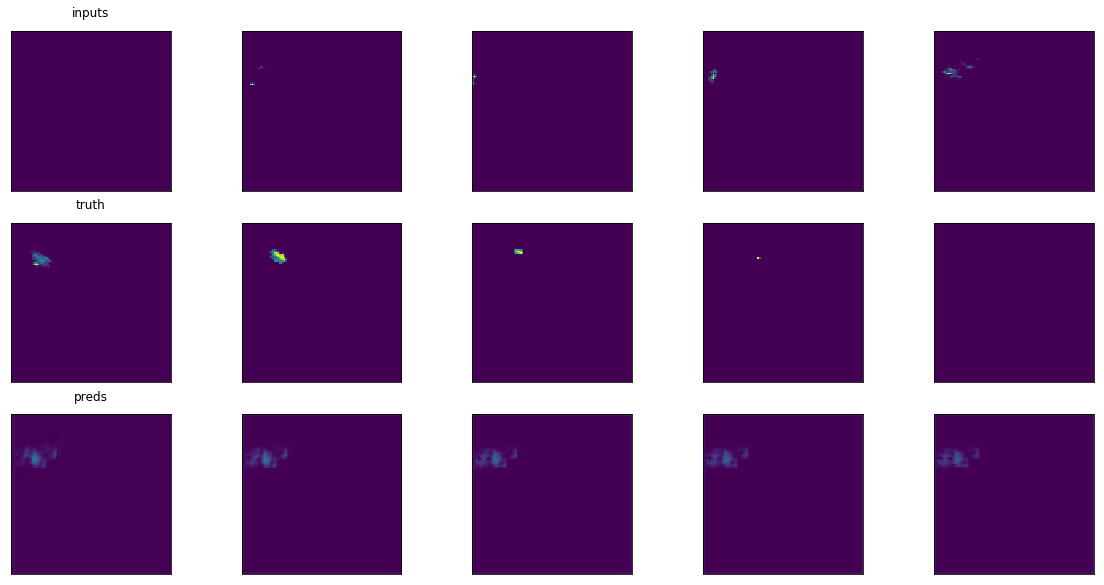

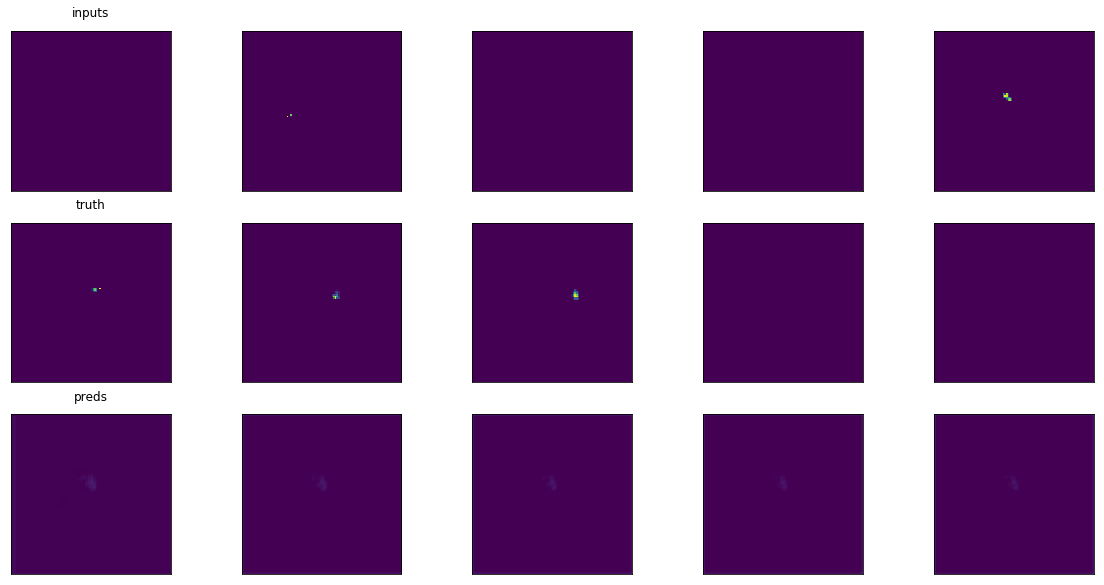

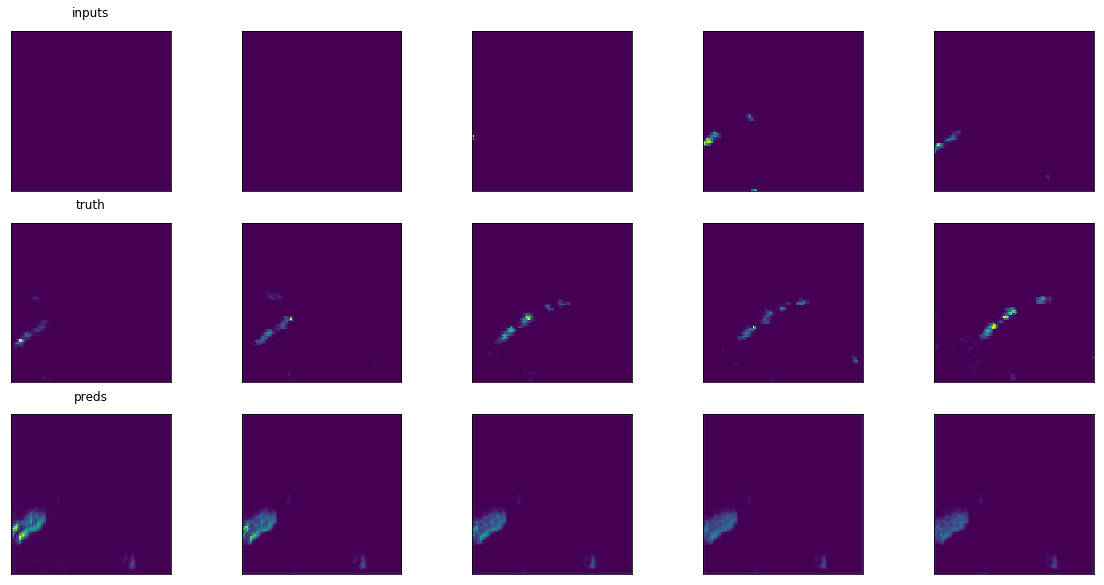

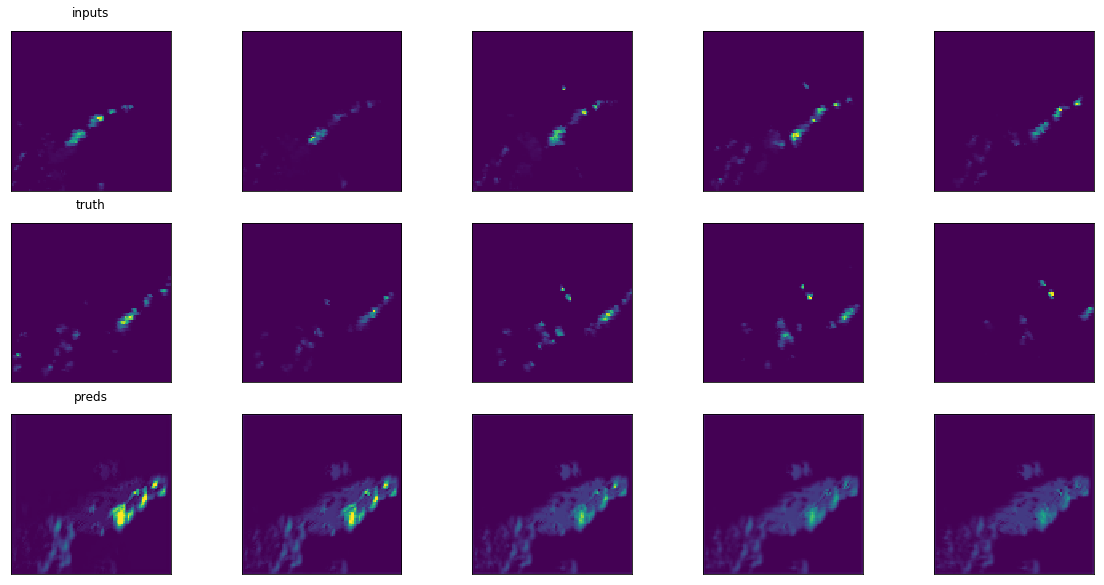

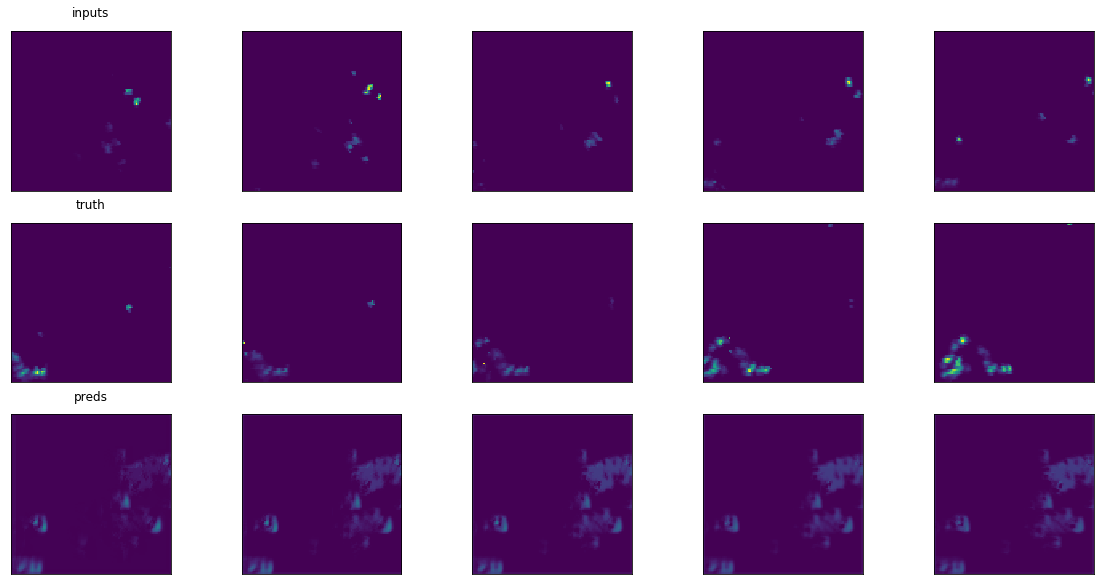

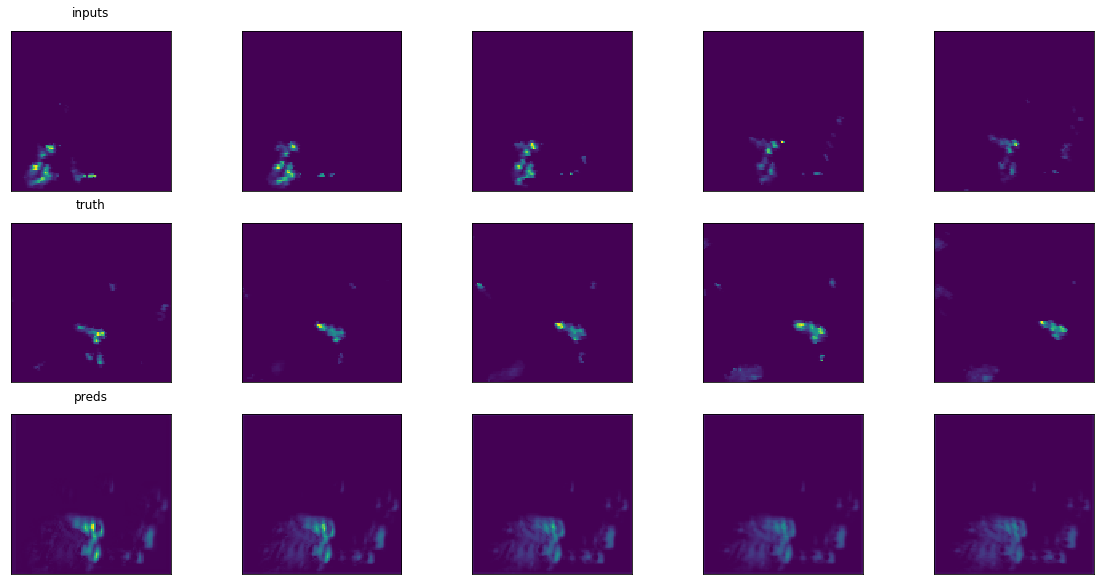

In [25]:
show_outputs(cnn, val_loader)